# Generalized Linear Models and Multilevel Models Application to Predict The Success of Bank Telemarketing

This notebook includes all code details about this study.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


import pymc3 as pm
import arviz as az

import daft

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
df = pd.read_csv('bank-additional.csv',sep=";")

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4119 entries, 0 to 4118
Data columns (total 26 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             4119 non-null   int64  
 1   job             4119 non-null   object 
 2   marital         4119 non-null   object 
 3   education       4119 non-null   object 
 4   default         4119 non-null   object 
 5   housing         4119 non-null   object 
 6   loan            4119 non-null   object 
 7   contact         4119 non-null   object 
 8   month           4119 non-null   object 
 9   day_of_week     4119 non-null   object 
 10  duration        4119 non-null   int64  
 11  campaign        4119 non-null   int64  
 12  pdays           4119 non-null   int64  
 13  previous        4119 non-null   int64  
 14  poutcome        4119 non-null   object 
 15  emp.var.rate    4119 non-null   float64
 16  cons.price.idx  4119 non-null   float64
 17  cons.conf.idx   4119 non-null   f

The bank dataset includes 10 numeric attributes and 11 categorical attributes. One of the categorical attributes is the target. The dataset includes 4119 non-null observations.

In [3]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000,4119.000000
mean,40.113620,256.788055,2.537266,960.422190,0.190337,0.084972,93.579704,-40.499102,3.621356,5166.481695
std,10.313362,254.703736,2.568159,191.922786,0.541788,1.563114,0.579349,4.594578,1.733591,73.667904
min,18.000000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.635000,4963.600000
25%,32.000000,103.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.334000,5099.100000
50%,38.000000,181.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.000000,317.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,88.000000,3643.000000,35.000000,999.000000,6.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


In [4]:
df.describe(include='object')

,job,marital,education,default,housing,loan,contact,month,day_of_week,poutcome,y
count,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119,4119
unique,12,4,8,3,3,3,2,10,5,3,2
top,admin.,married,university.degree,no,yes,no,cellular,may,thu,nonexistent,no
freq,1012,2509,1264,3315,2175,3349,2652,1378,860,3523,3668


   **Input variables:**
   
   Bank client data:
   
   1 - age (numeric)
   
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")
   
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)
   
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")
   
   5 - default: has credit in default? (categorical: "no","yes","unknown")
   
   6 - housing: has housing loan? (categorical: "no","yes","unknown")
   
   7 - loan: has personal loan? (categorical: "no","yes","unknown")
   
   
   Related with the last contact of the current campaign:
   
   8 - contact: contact communication type (categorical: "cellular","telephone") 
   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")
   
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")
  
  11 - duration: last contact duration, in seconds (numeric).
  
  
 Other attributes:
 
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 0 means client was not previously contacted)
  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)
  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")
  
  
  Social and economic context attributes:
  
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)     
  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)    
  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
  
  20 - nr.employed: number of employees - quarterly indicator (numeric)

  Output variable (desired target):
  
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")

The summary statistics are given above. They will be analyzed in the following sections.

# Exploratory Data Analysis

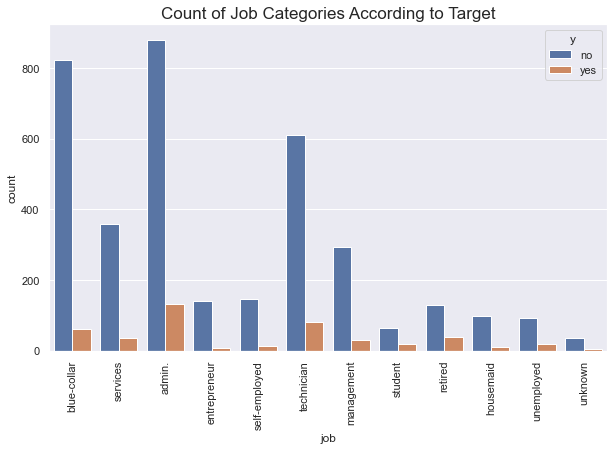

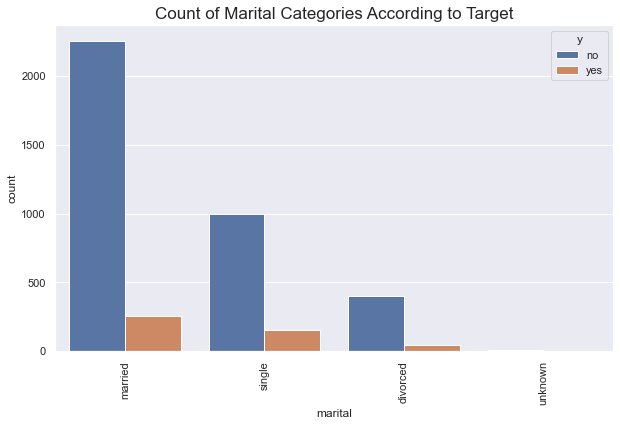

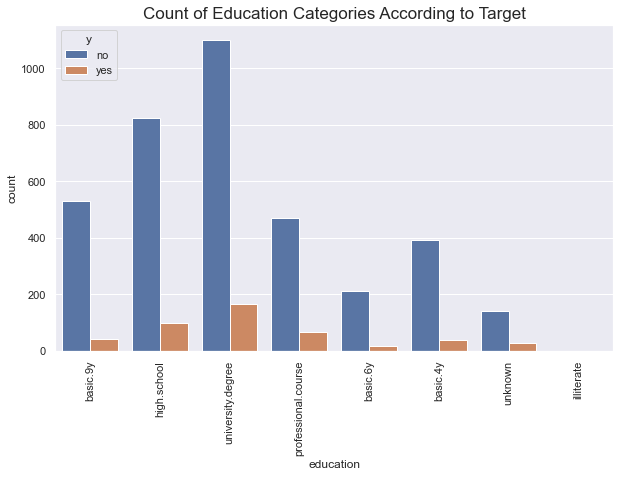

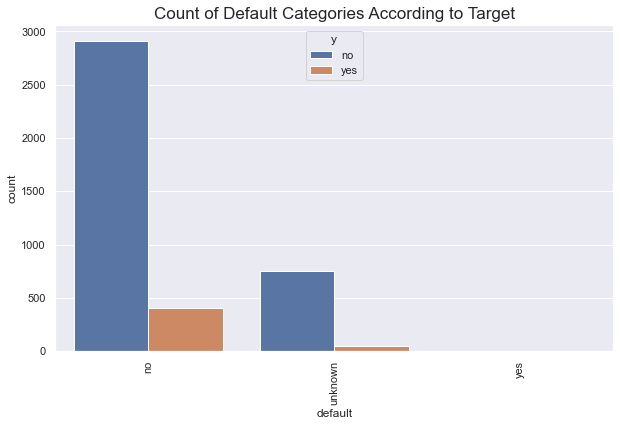

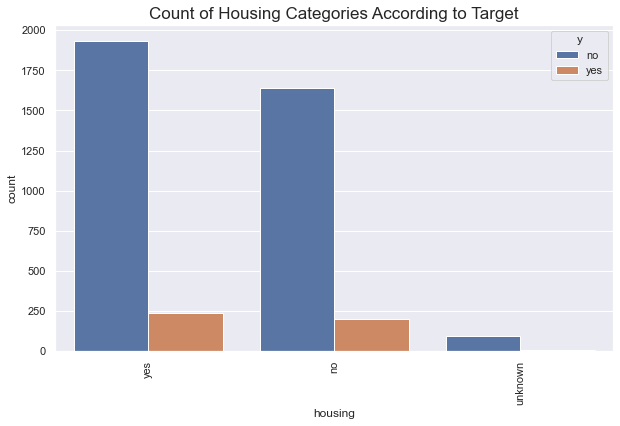

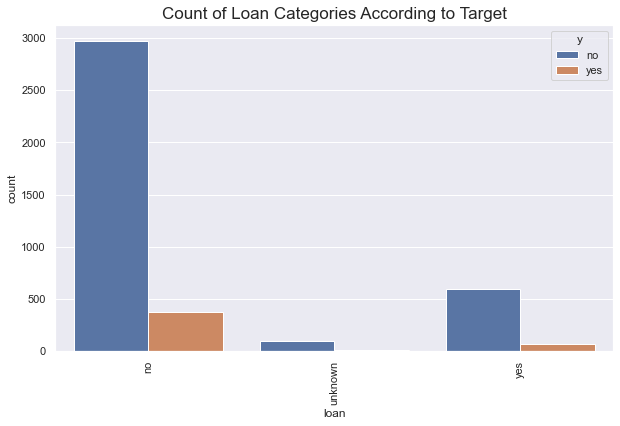

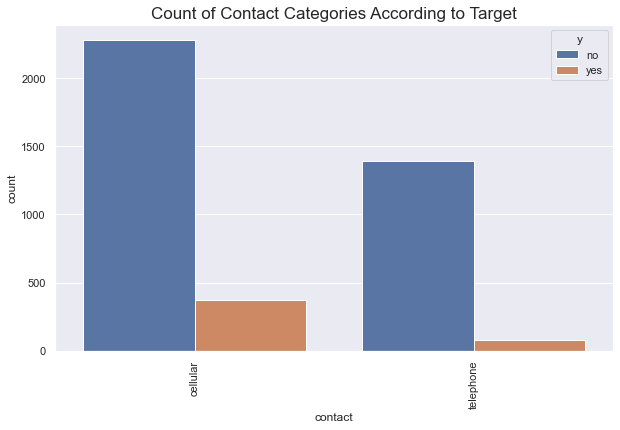

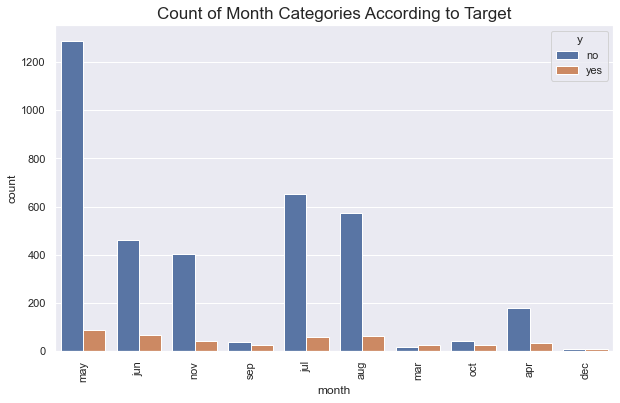

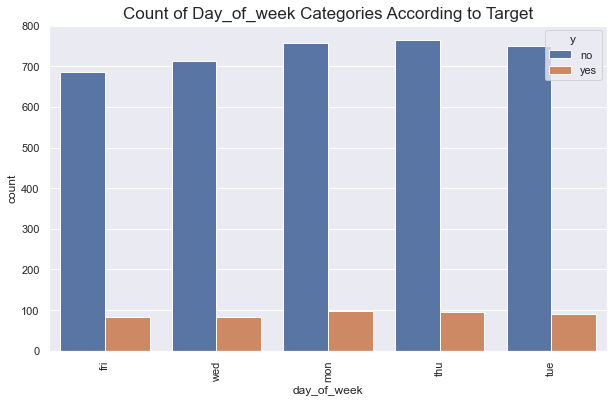

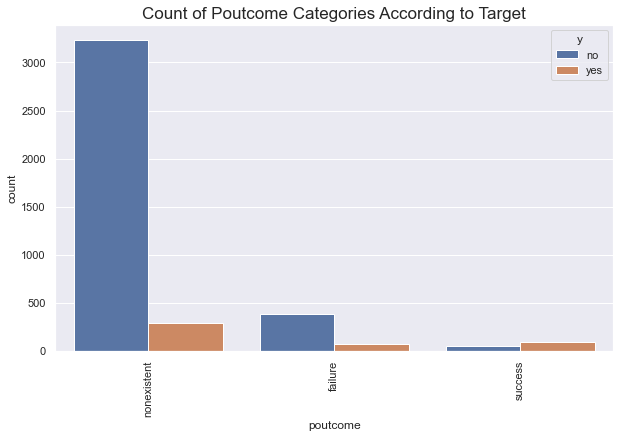

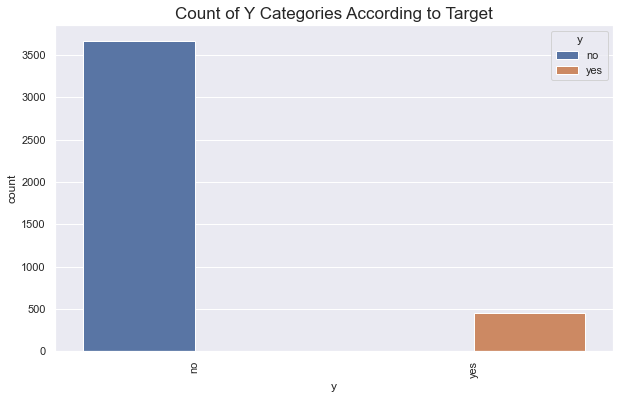

In [21]:
#visualize the categorical values according to the target values
#analyze the class distribution
cat_list=['job','marital','education','default','housing','loan','contact','month','day_of_week','poutcome','y']
for cat in cat_list:
    sns.set(rc={'figure.figsize':(10,6)})
    sns.countplot(x=cat, data=df, hue="y")
    plt.xticks(rotation=90)
    plt.title("Count of {} Categories According to Target".format(cat.capitalize()),  fontsize=17)
    plt.show()

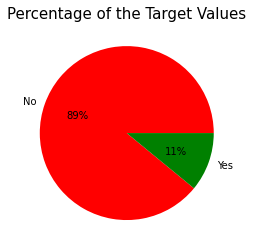

In [25]:
# target data
class_count = [df['y'].value_counts()[0], df['y'].value_counts()[1]]

class_t = ['No', 'Yes']

# create pie chart using matplotlib
plt.pie(class_count, labels=class_t, colors=['red','green'], autopct='%.0f%%')
plt.title("Percentage of the Target Values",  fontsize=15)
plt.show()

According to the class distribution given above, it is obvious to say that the class distribution of the target is not evenly equal for the categorical values. 89% of customers rejected, and 11% of customers accepted the term deposit. 

The most prominent inferences from these count plots;

* There are slight changes between the number of yes or no values in 'day_of_week' values. But the month values differentiate according to month.
* Most of the clients are admins and the most yes answers came from them
* 'Poutcome' is the outcome of the previous marketing campaign, the results show that the most of the customer has no previous contact with the previous campaigns (nonexistent)


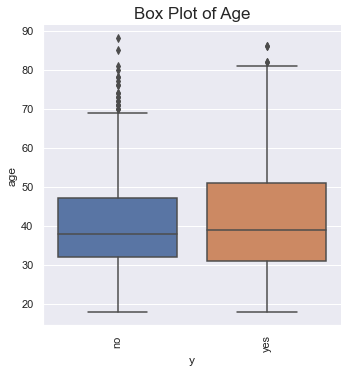

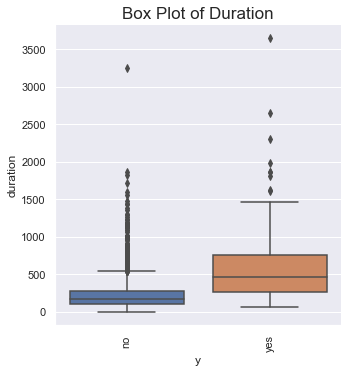

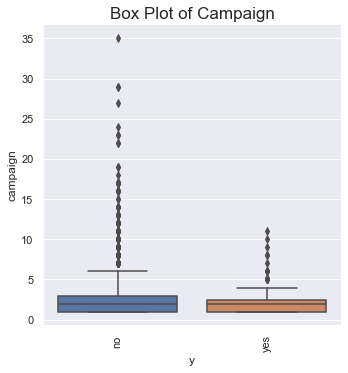

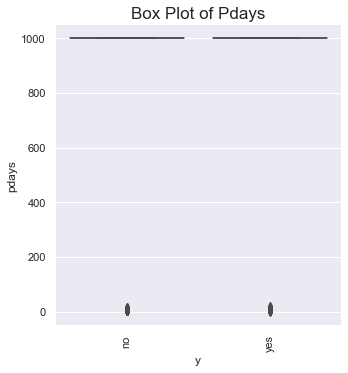

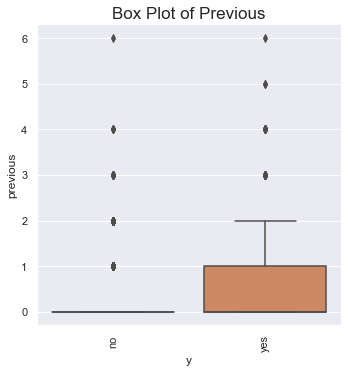

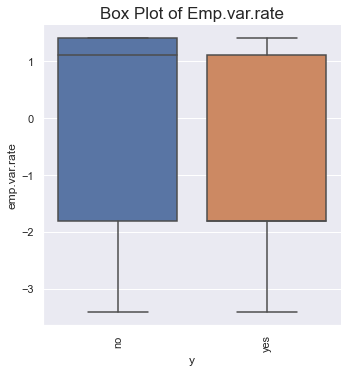

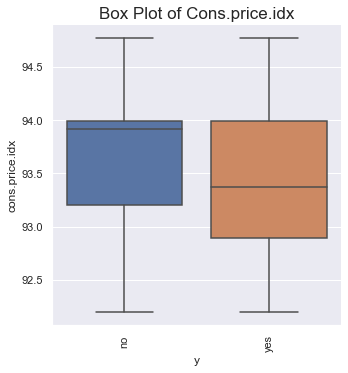

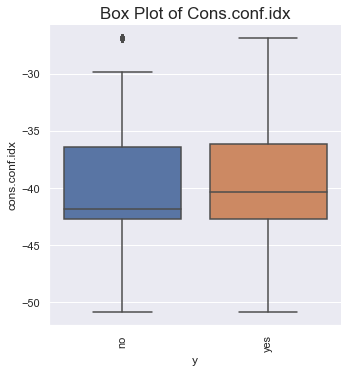

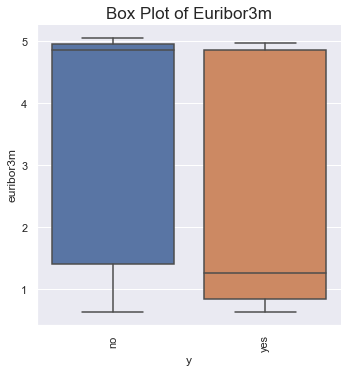

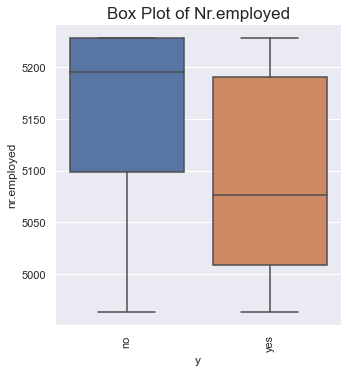

In [32]:
num_list=["age","duration","campaign","pdays","previous","emp.var.rate",
          "cons.price.idx","cons.conf.idx","euribor3m","nr.employed"]

for num in num_list:
    sns.set(rc={'figure.figsize':(10,6)})
    sns.catplot(x="y", y=num, data=df, kind="box")
    plt.xticks(rotation=90)
    plt.title("Box Plot of {}".format(num.capitalize()),  fontsize=17)
    plt.show()

The most prominent inferences from these box plots;

* The campaign (number of contacts performed during this campaign and for this client) attributes mostly are in the 1 and 3. But there are more contact numbers with clients. There are clients who reject the offer of a long-term deposit although they have the highest number of the contacts.
* The customers have a higher mean and value duration of the last contact who accepts the term deposit. 
* There are very few values different from zero in the 'pdays'(number of days that passed by after the client was last contacted from a previous campaign) attributes. 

In [29]:
pd.crosstab(df.job, df.y, margins=True)

#https://pbpython.com/pandas-crosstab.html

y,no,yes,All
job,,,
admin.,879,133,1012
blue-collar,823,61,884
entrepreneur,140,8,148
housemaid,99,11,110
management,294,30,324
retired,128,38,166
self-employed,146,13,159
services,358,35,393
student,63,19,82


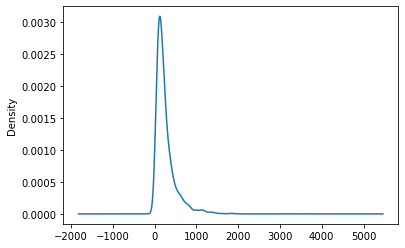

In [50]:
df['duration'].plot(kind='kde')

# Problem Definition

Marketing informs the customers about the products or services companies are offering them. There are a lot of sectors and industries using marketing strategies to promote their products or services. The data-driven approaches support the marketing strategies by using meaningful information about the companies and customers. In this study, the success of bank telemarketing will be interpreted by using proper statistical approaches. Telemarketing is the most preferable and very common interactive marketing way in the financial area. In this study, the purpose is the analyzing effect of the telemarketing actions and attributes on the customer subscription of the long-term deposit, which is considered an output variable.

Before starting the criticism of the relation between the attributes of the dataset, the casual DAG graph should be drawn.

The whole DAG graph of all variables is given below.

**AG**: Age            ----      **PD**: Pdays       ----           **EM**: Number of Employees

**ED**: Education Level  ----    **PR**: Previous      ----         **EV**: Employment Variation Rate

**MS**: Marital Status   ----    **PO**: Poutcome      ----         **CP**: Consumer Price Index

**JB**: Job            ----      **CA**: Campaign      ----         **CC**: Consumer Confidence Index

**HL**: Housing loan      ----   **DU**: Duration      ----         **E3**: Euribor 3 Month Rate

**DF**: Default       ----       **DW**: Day of Week

**LO**: Loan         ----        **MO**: Month

**Y**: Target       ----         **CN**: Contact

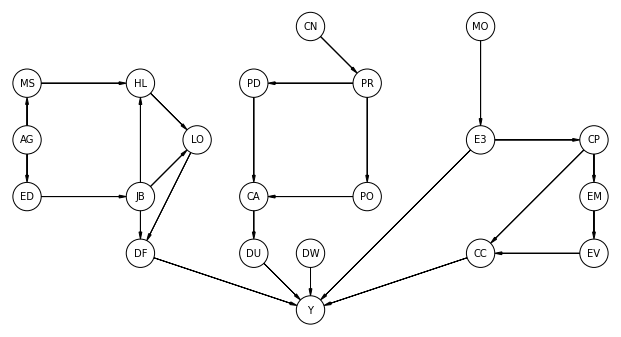

In [107]:
import daft
pgm = daft.PGM()

#nodes
pgm.add_node("AG", "AG",0,2) 
pgm.add_node("ED", "ED",0,1) 
pgm.add_node("MS", "MS",0,3) 
pgm.add_node("JB", "JB",2,1) 
pgm.add_node("HL", "HL",2,3) 
pgm.add_node("DF", "DF",2,0) 
pgm.add_node("LO", "LO",3,2) 

pgm.add_node("CN", "CN",5,4)
pgm.add_node("PD", "PD",4,3) 
pgm.add_node("PR", "PR",6,3) 
pgm.add_node("PO", "PO",6,1) 
pgm.add_node("CA", "CA",4,1) 
pgm.add_node("DU", "DU",4,0) 
pgm.add_node("DW", "DW",5,0)
pgm.add_node("Y", "Y",5,-1) 


pgm.add_node("EM", "EM",10,1) 
pgm.add_node("EV", "EV",10,0) 
pgm.add_node("CP", "CP",10,2) 
pgm.add_node("CC", "CC",8,0) 
pgm.add_node("E3", "E3",8,2) 
pgm.add_node("MO", "MO",8,4) 



#edges
pgm.add_edge("AG", "ED") #age->education level
pgm.add_edge("AG", "MS") #age->marital status
pgm.add_edge("ED", "JB") #education level->job
pgm.add_edge("JB", "DF") #job->default
pgm.add_edge("JB", "HL") #job->housing loan
pgm.add_edge("JB", "LO") #job->loan
pgm.add_edge("MS", "HL") #marital status->housing loan
pgm.add_edge("HL", "LO") #housing loan->loan
pgm.add_edge("LO", "DF") #loan->default
pgm.add_edge("DF", "Y")  #default->target

pgm.add_edge("CN", "PR") #contact->previous
pgm.add_edge("PR", "PD") #previous->pdays
pgm.add_edge("PR", "PO") #previous->poutcome
pgm.add_edge("PD", "CA") #pdays->campaign
pgm.add_edge("PO", "CA") #poutcome->campaign
pgm.add_edge("CA", "DU") #campaign->duration
pgm.add_edge("DU", "Y") #duration->target
pgm.add_edge("DW", "Y") #day of week->target

pgm.add_edge("MO", "E3") #month->euribor 3 month rate
pgm.add_edge("E3", "CP") #euribor 3 month rate ->consumer price index
pgm.add_edge("E3", "Y") #euribor 3 month rate ->target
pgm.add_edge("CP", "CC") #consumer price index->consumer confidence index
pgm.add_edge("CP", "EM") #consumer price index->number of employee
pgm.add_edge("EM", "EV") #number of employee->employment variation rate
pgm.add_edge("EV", "CC") #employment variation rate->consumer confidence index
pgm.add_edge("CC", "Y") #consumer confidence index->target

#pgm.add_edge("EM", "JB") #number of employee->job
#pgm.add_edge("DF", "PR")  #default->previous
####target

pgm.render()

Causal graph assumptions;

Bank client data;

* Age affects the education level, education depends on the age.
* Age affects the marital status, marital status depends on the age.
* Education level affects having a job and also the type of the job. 
* Job and marital status have an effect on having a housing loan. For example, if the client is just married, can want to have a house. And the job status will affect the getting a housing loan.
* The relationship between having a housing loan, loan, and credits(default) is thought of like this; if the customers don't have a housing loan, can tend to have a loan, and if the customers don't have a loan, can tend to be using credits.
* The job status also affects the having loan and credits separately.

Data related to the last contact of the current and previous campaign;
* The number of previous contact(PR) affects the number of days that passed after the client was last contacted from a previous campaign. If there is so much contact between the client and agent, the time interval between the last contact and current contact will be affected by this.
* The number of previous contacts (PR) can be a sign of the customer's interest in the bank and offers from the bank. If the bank has a strong connection with the client, the probability of getting 'yes' response to the offer will increase. So the number of the previous contacts directly affects the previous marketing outcome. 
* the number of days that passed by after the client was last contacted from a previous campaign can change the customer preferences for bank choices or deposit needs. During the elapsed time, customers can change decisions about the bank, can get different good offers from other banks, etc. So, it will affect the customer's current attention. The number of contacts performed during this campaign and for this client is an indicator of this.
* The number of contacts performed during this campaign and for this client will affect the last contact duration. How much clients allow to communicate with them will affect the communication duration. 
* The duration of the last contact is an important indicator of customer interest. How much the agent can keep the customer held in connection, can increase the possibility of the customer acceptance.
* According to the client's workload, the client can be busier on the specific days of the week and can't give enough time to interest the offer. But some other days the situation can be different. It's just an assumption and should be verified. So the day of the week can affect the target.
* The default(has credit in default) value can change the interest and willingness of the customer. Because of this, the default value can affect the number of previous contacts.

Social and economic context attributes;
* Euribor 3m directly affects both consumer price index and target.
* If interest rates fall, inflation rises. Inflation affects the consumer price index. 
* If inflation increases, the number of employees decreases, which affects and increases the employment variation rate, which directly affects the consumer confidence index. The consumer price index is the indicator of whether the customers feel safe spending their money or need to save money. It directly affects the target. And also the consumer price index affects the customer's feeling of confidence. 
* The Euro Interbank Offered Rate is a daily reference rate, published by the European Money Markets Institute, based on the averaged interest rates at which Eurozone banks offer to lend unsecured funds to other banks in the euro wholesale money market. Thus it will really affect the interest rate which is offered by the bank. It means that the interest rate is very important to decide whether the customer will invest their money in this bank. So euribor3m has a direct effect on the target variable. And it's affected by the month of the year. When considering the Euribor rate, one might think that a lower Euribor would result in a decline in savings rate since most European banks align their deposit interest rate offers with ECB indexes, particularly with the three month Euribor(Reilly, 2005)

Reilly, G. O. (2005). Information in financial market indicators: an overview. Quarterly Bulletin Articles, 4, 133-141.


# Data Transformation

We need to standardize and encode the attributes to create models with this dataset. The actions to do this are given below.

In [121]:
#standardize the last contact duration
df['d']= (df['duration']-df['duration'].mean())/df['duration'].std()

#standardize the number of contacts performed before this campaign and for this client (previous)
df['pr']= (df['previous']-df['previous'].mean())/df['previous'].std()

#standardize the target(has the client subscribed a term deposit? Yes or no)
df['t']=(df['y'] == "yes").astype(int).values

#standardize the number of contacts performed during this campaign and for this client (current)
df['ca']= (df['campaign']-df['campaign'].mean())/df['campaign'].std()

In [70]:
#encode the features have more than one option
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#encode the previous outcome
df["po"] = le.fit_transform(df['poutcome'])
print(dict(zip(le.classes_, range(len(le.classes_)))))

#encode the day of week
df["dw"] = le.fit_transform(df["day_of_week"])
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'failure': 0, 'nonexistent': 1, 'success': 2}
{'fri': 0, 'mon': 1, 'thu': 2, 'tue': 3, 'wed': 4}


In [72]:
#turn pdays values 999 into 0
df.loc[df["pdays"] == 999, "pdays"] = 0

# Scientific Models

By taking a reference from other studies, firstly the causal effect of the **duration** on the target will be a good starting point. If we look at the DAG, ’duration’ has a direct relation to the target. There are no mid attributes between them. There are other attributes that have an effect on the duration. They will be analyzed in the following sections.

The duration can be the main factor which can be the sign of the customer's willingness. As an assumption, if the customer and agent have long phone calls, the percentage of convincing the customer can increase. 

In this dataset, each row represents a different customer. We’ll use the Bernoulli distribution as a target distribution. Because the target only has 2 results; yes or no. And there is no more than one trial for the recent campaign. We’ll use the Generalized Linear Models to interpret the effect. GLMs use a link function to turn the bounded parameter into an unbounded space so that it can be estimated by a linear function. The inverse of the logit link function was used to estimate the probabilities of each outcome of the Bernouilli distribution.

$$
\begin{align*}
G_i &\sim \text{Bernoulli}(p_i)
\\
logit(p_i) &= \alpha_{[i]} + \beta_{[i]} * Duration
\\
\alpha_j &\sim Normal(0, 1.5)
\\
\beta_j &\sim Normal(0, 1)
\end{align*}
$$

*Not:Because of the processing 4000 row data will take a lot of time, the random 1030 samples are taken from the dataset. 

In [120]:
d = df.sample(frac=0.25, replace=True, random_state=1)

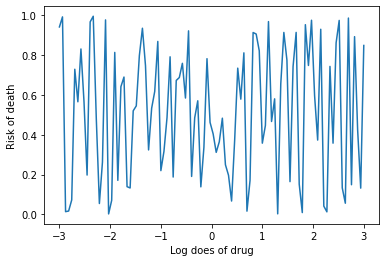

In [162]:
#to test and visualize the priors
f = lambda a, b, xp: np.exp(a + b*xp)/(1 + np.exp(a + b*xp))

xp = np.linspace(-3, 3, 100)
a = np.random.normal(0, 1.5, 100)
b= np.random.normal(0, 1, 100)
plt.plot(xp, f(a, b, xp)),
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death');

In [60]:
#duration -> target (direct or total)
#logit(pi)=α+βxi
with pm.Model() as model_DT:
    alpha = pm.Normal('alpha', 0, 1.5) #intercept
    beta = pm.Normal('beta', 0, 1)  
    p = pm.math.invlogit(alpha + beta * d.d)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_DT = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1154 seconds.


In [66]:
az.summary(trace_DT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.526,0.131,-2.775,-2.283,0.003,0.002,2430.0,2420.0,1.0
beta,1.130,0.110,0.912,1.325,0.002,0.002,2428.0,2483.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2EC1B5B20>,
      dtype=object)

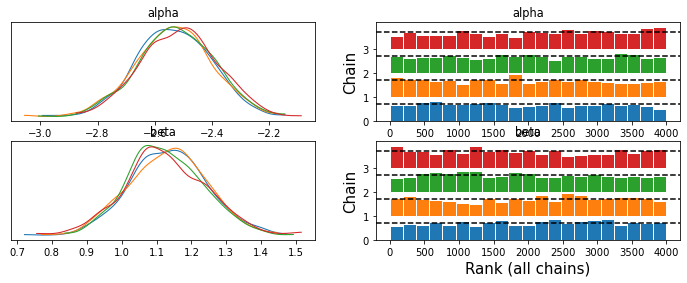

In [173]:
az.plot_trace(trace_DT, kind="rank_bars", compact=False)

array([<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2D14496D0>,
      dtype=object)

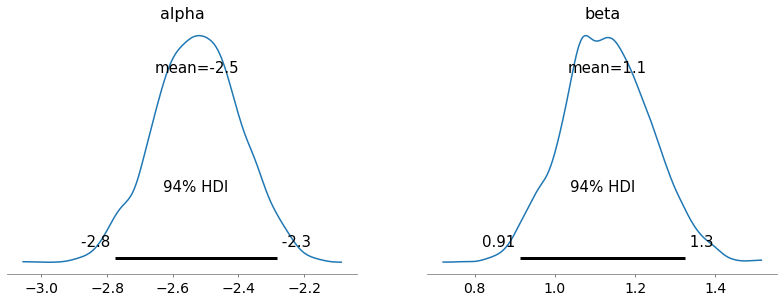

In [73]:
az.plot_posterior(trace_DT, hdi_prob=0.94)

According to the summary tables given below, r_hat shows that the model with only duration and intercept is working well. The mean of the duration is 1.130 which has a positive effect on the target. If the duration has zero value, the intercept (alpha) has a negative value. It is reasonable that when the customer was not taken a call for the last campaign, there is no chance to accept to offer. There is one value like this in the dataset.

The beta value shows the mean effect of the duration on the target. The last call duration has a positive effect on the acceptance of the client. The elapsed time helps to convince the customer by providing more time to the agent to explain the details of the campaign.

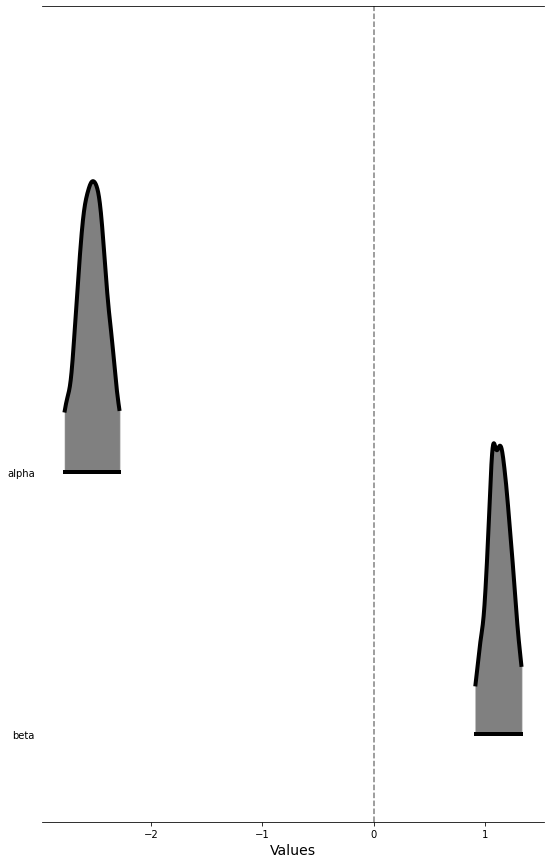

In [74]:
axes = az.plot_forest(
    trace_DT,
    kind="ridgeplot",
    linewidth=4,
    combined=True,
    ridgeplot_overlap=1.5,
    colors="gray",
    figsize=(9, 15),
)
axes[0].set_xlabel("Values", fontsize= 14)
axes[0].axvline(0,color="k",alpha=0.5, linestyle="--")

Another issue about the target that is important to research is the effect of the outcome of the previous marketing campaign on the acceptance of the current campaign. According to DAG given in the previous section, to find the direct effect of the previous outcome, the model was created which includes the previous number of contact and duration attributes in the logit link function. Especially, the previous number of contact was included to model to stratify the previous effect on the number of contact of the current campaign and the last call duration. 

In [61]:
#poutcome -> target (direct)
#stratify previous and duration 

#logit(pi)=α[0,1]+βxi(duration)+ thetayi(previous)

with pm.Model() as model_PT:
    alpha = pm.Normal('alpha', 0, 1, shape=3) 
    beta = pm.Normal('beta', 0, 1)  
    theta = pm.Normal('theta', 0, 1)
    p = pm.math.invlogit(alpha[d.po] + beta * d.d + theta * d.pr)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_PT = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2293 seconds.


In [67]:
az.summary(trace_PT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[0],-2.762,0.405,-3.552,-2.041,0.009,0.006,2150.0,2369.0,1.0
alpha[1],-2.855,0.175,-3.178,-2.527,0.003,0.002,2503.0,2775.0,1.0
alpha[2],0.068,0.490,-0.887,0.941,0.010,0.007,2278.0,2673.0,1.0
beta,1.190,0.116,0.979,1.411,0.002,0.002,2723.0,2904.0,1.0
theta,0.311,0.153,0.036,0.600,0.004,0.002,1910.0,2474.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2EC4BC700>,
      dtype=object)

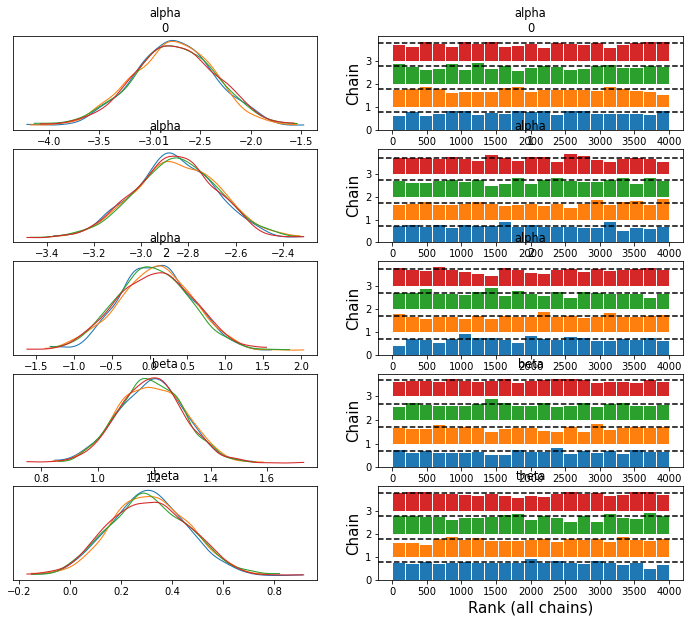

In [174]:
az.plot_trace(trace_PT, kind="rank_bars", compact=False)

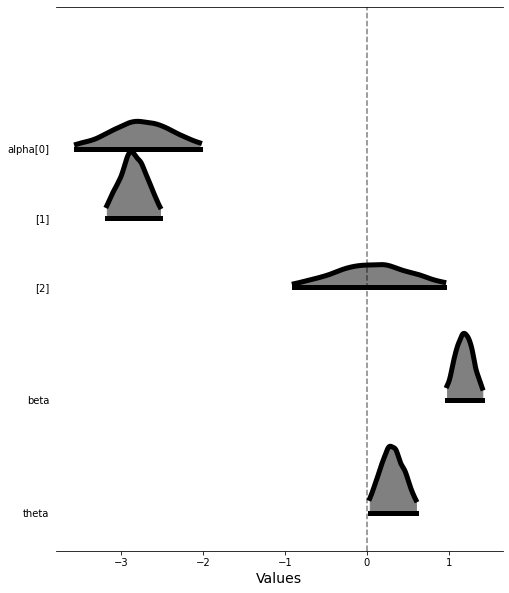

In [92]:
axes = az.plot_forest(
    trace_PT,
    kind="ridgeplot",
    linewidth=5,
    combined=True,
    ridgeplot_overlap=0.8,
    colors="gray",
    figsize=(8, 10),
)
axes[0].set_xlabel("Values", fontsize= 14)
axes[0].axvline(0,color="k",alpha=0.5, linestyle="--")

According to the summary table, r_hat and effective sample sizes show the model is convenient to analyze this issue. The alpha values which represent the previous campaign outcomes show that if the customer rejected the previous campaign or does not have any contact with the previous campaign, the effect of these kinds of customers on the target, is negative (alpha 0 and 1). It means that if the customer rejects the previous campaign probably will reject the next one, or if the customer does not have any contact and collaboration with the bank, it will be hard to convince the customer for the next campaign.

The interesting part is that the customer's acceptance of the previous campaign offer almost does not affect the next campaign result. It means that there are some other factors that have the more strong effect on the acceptance of the offer. One of them is the duration of the last call which is explained in the previous model.  

Another question of interest is the effect of the day of the week on the target. In the descriptive analyzing part, the count plot of the day of the week according to the target value stood out. This plot shows us that there are almost no differences between the day of the week. This assumption was analyzed by the modeling below.

The possible differences between the day of the week are counted as a cluster. The multi-level modeling was created. There are 5 different days in this dataset. Every day has its own distribution and variance to show how the days are different.

In [62]:
#apply multilevel model to look day_of_week affect
#add the day_of_week
#logit(pi)=α[0,1]+βxi(duration)+ thetayi(previous) + gamma[i as a cluster]

with pm.Model() as model_MPT:
    #to multilevel dow
    gamma_bar = pm.Normal('gamma_bar', 0, 1.5) #gamma bar for each cluster
    sigma = pm.Exponential('sigma', 1) #each day the answer of customer can change
    gamma = pm.Normal('gamma', gamma_bar, sigma, shape = 5)
    
    alpha = pm.Normal('alpha', 0, 1, shape=3) 
    beta = pm.Normal('beta', 0, 1) 
    theta = pm.Normal('theta', 0, 1)
    p = pm.math.invlogit(alpha[d.po] + beta * d.d + theta * d.pr + gamma[d.dw])
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_MPT = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha, gamma, sigma, gamma_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6700 seconds.
There were 134 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.7144398980231783, but should be close to 0.8. Try to increase the number of tuning steps.
There were 93 divergences after tuning. Increase `target_accept` or reparameterize.
There were 159 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.6834876862824939, but should be close to 0.8. Try to increase the number of tuning steps.
There were 131 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


In [68]:
az.summary(trace_MPT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_bar,-1.893,0.630,-3.199,-0.720,0.046,0.033,190.0,184.0,1.03
gamma[0],-1.889,0.639,-3.058,-0.499,0.046,0.033,195.0,196.0,1.03
gamma[1],-1.753,0.642,-2.921,-0.375,0.046,0.033,198.0,182.0,1.03
gamma[2],-1.955,0.648,-3.379,-0.806,0.047,0.033,195.0,182.0,1.03
gamma[3],-1.976,0.649,-3.240,-0.708,0.047,0.033,193.0,201.0,1.03
gamma[4],-1.996,0.643,-3.342,-0.816,0.046,0.033,200.0,196.0,1.03
alpha[0],-1.343,0.601,-2.366,-0.153,0.036,0.025,282.0,429.0,1.02
alpha[1],-0.953,0.639,-2.163,0.351,0.046,0.034,204.0,200.0,1.02
alpha[2],1.430,0.645,0.055,2.548,0.040,0.031,281.0,230.0,1.03
beta,1.229,0.118,1.016,1.451,0.006,0.004,377.0,780.0,1.02


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2D9B45340>,
      dtype=object)

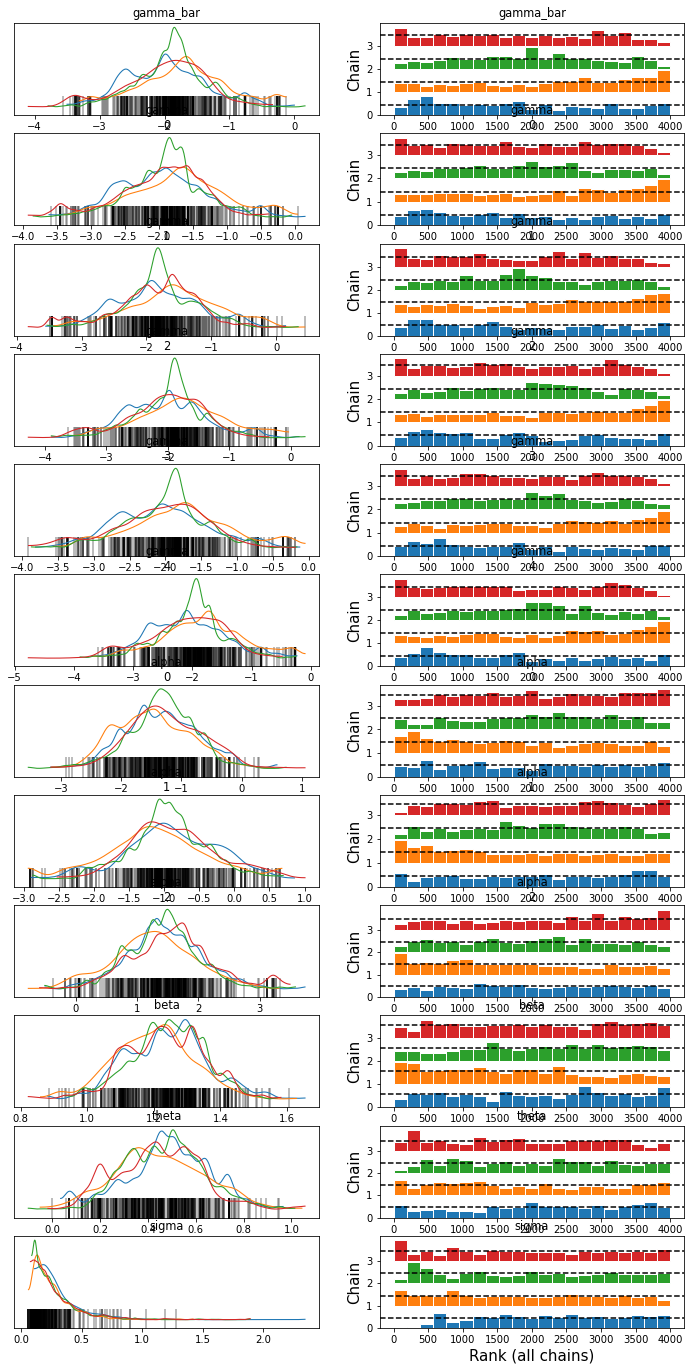

In [175]:
az.plot_trace(trace_MPT, kind="rank_bars", compact=False)

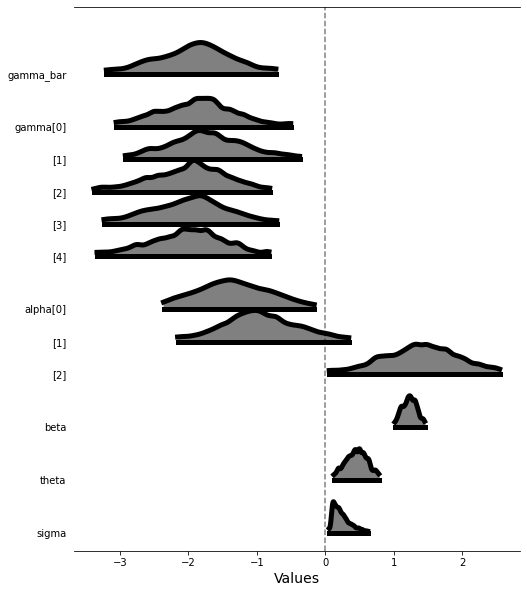

In [93]:
axes = az.plot_forest(
    trace_MPT,
    kind="ridgeplot",
    linewidth=5,
    combined=True,
    ridgeplot_overlap=0.8,
    colors="gray",
    figsize=(8, 10),
)
axes[0].set_xlabel("Values", fontsize= 14)
axes[0].axvline(0,color="k",alpha=0.5, linestyle="--")

The gamma values show that there is no differential effect between the day of the week on the target. Treating the day of the week as a cluster and adding them to the multi-level model is not an appropriate approach. So,  it gave the parallel result with the plot drawn. 

So, the centered version of the multi-level model given above has a lot of divergences, bad r_hat results, and a very low number of effective samples. Only to get a proper result the non-centered version was created which is shown below.

In [63]:
#apply multilevel model to look day_of_week affect
#add the day_of_week
#logit(pi)=α[0,1]+βxi(duration)+ thetayi(previous) + gamma[i as a cluster]
#make noncentered

with pm.Model() as model_NMPT:
    #to multilevel dow
    gamma_bar = pm.Normal('gamma_bar', 0, 1.5) #gamma bar for each cluster
    sigma = pm.Exponential('sigma', 1) #each day the answer of customer can change
    z = pm.Normal('z', 0.0, 1.0, shape = 5)
    
    alpha = pm.Normal('alpha', 0, 1, shape=3) 
    beta = pm.Normal('beta', 0, 1)  
    theta = pm.Normal('theta', 0, 1)
    p = pm.math.invlogit(alpha[d.po] + beta * d.d + theta * d.pr + gamma_bar + z[d.dw]*sigma)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_NMPT = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta, alpha, z, sigma, gamma_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 42065 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


In [69]:
az.summary(trace_NMPT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_bar,-1.909,0.596,-3.044,-0.821,0.015,0.011,1558.0,1974.0,1.0
z[0],0.040,0.879,-1.592,1.729,0.015,0.015,3624.0,2785.0,1.0
z[1],0.490,0.895,-1.157,2.243,0.016,0.013,3181.0,2669.0,1.0
z[2],-0.122,0.881,-1.710,1.569,0.015,0.016,3291.0,2160.0,1.0
z[3],-0.207,0.900,-1.826,1.578,0.016,0.015,3296.0,2646.0,1.0
z[4],-0.250,0.868,-1.915,1.367,0.014,0.015,3872.0,2659.0,1.0
alpha[0],-1.371,0.622,-2.483,-0.151,0.015,0.011,1734.0,2346.0,1.0
alpha[1],-0.949,0.612,-2.160,0.155,0.015,0.011,1627.0,2164.0,1.0
alpha[2],1.391,0.643,0.216,2.620,0.015,0.011,1829.0,2246.0,1.0
beta,1.227,0.114,1.017,1.441,0.002,0.001,3523.0,2612.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2EC70BCA0>,
      dtype=object)

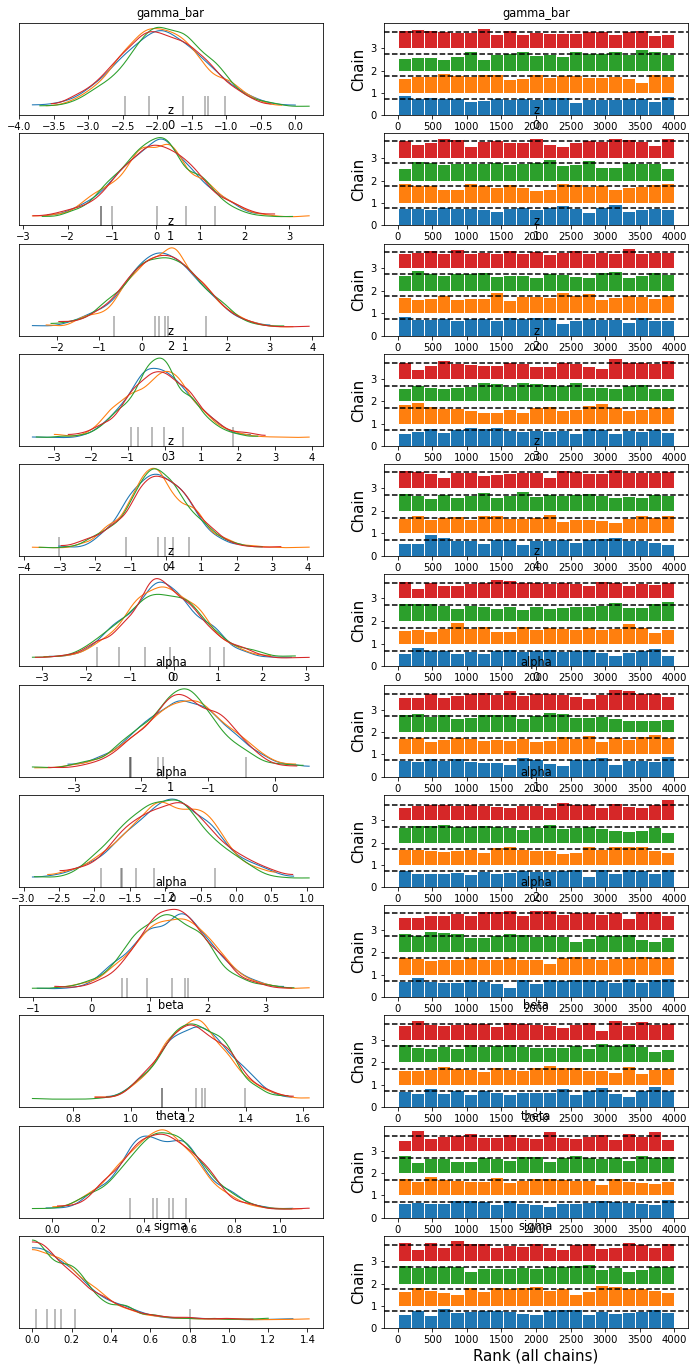

In [176]:
az.plot_trace(trace_NMPT, kind="rank_bars", compact=False)

The proper r_hat values were obtained. And the number of effective samples is really increasing according to the previous centered model. This model will be used to compare the model performances.

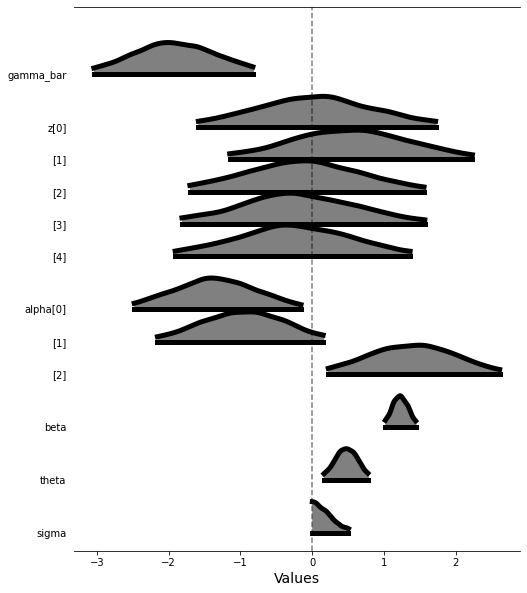

In [179]:
axes = az.plot_forest(
    trace_NMPT,
    kind="ridgeplot",
    linewidth=5,
    combined=True,
    ridgeplot_overlap=0.8,
    colors="gray",
    figsize=(8, 10),
)
axes[0].set_xlabel("Values", fontsize= 14)
axes[0].axvline(0,color="k",alpha=0.5, linestyle="--")

And also the last attribute of the marketing information, the 'campaign' was used to model. The 'campaign' is the number of contacts performed during this campaign and for this client. It is an indicator of the current campaign activities. The increase in the number of contacts can affect the target.

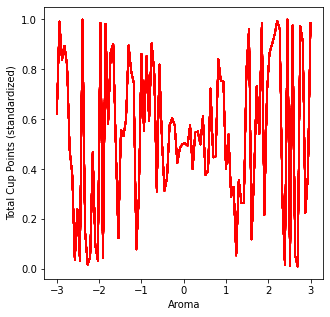

In [163]:
#To test and visualize priors
#f = lambda a, b, xp: np.exp(a + b*xp)/(1 + np.exp(a + b*xp))
f = lambda a, b, xp: np.exp((a*xp)+(b*xp))/(1 + np.exp((a*xp)+(b*xp)))


N = 100

#a = np.random.uniform(0,10,N)
a = np.random.normal(0, 1, N)
b= np.random.normal(0, 1,N)
#bAR = np.random.uniform(0,0.5,N)
xp = np.linspace(-3, 3, 100)

fig, ax = plt.subplots(figsize=(5,5))
for i in range(N):
    ax.plot(xp, f(a, b, xp), "r", alpha = 0.4)
    #ax.set_xlim(-2, 2)
    #ax.set_ylim(-2, 2)
    ax.set_xlabel("Aroma")
    ax.set_ylabel("Total Cup Points (standardized)")

In [125]:
#campaign -> target (direct)
#stratify only the duration 

#logit(pi)=βxi(duration)+ thetayi(current)

with pm.Model() as model_CT:
    beta = pm.Normal('beta', 0, 1)  
    theta = pm.Normal('theta', 0, 1)
    p = pm.math.invlogit(beta * d.d + theta * d.ca)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_CT = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, beta]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1200 seconds.


In [127]:
az.summary(trace_CT)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
beta,0.830,0.096,0.644,1.002,0.002,0.001,3257.0,2408.0,1.0
theta,-0.019,0.069,-0.144,0.110,0.001,0.001,3629.0,2763.0,1.0


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000002A2F088AAC0>,
      dtype=object)

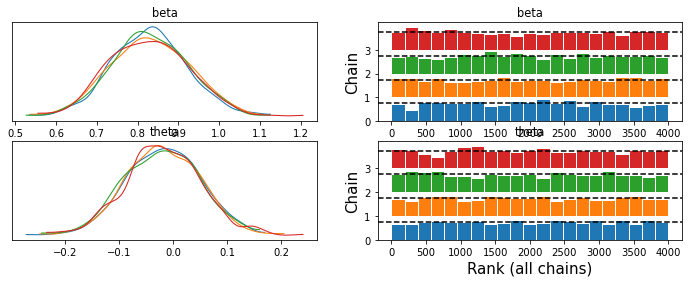

In [181]:
az.plot_trace(trace_CT, kind="rank_bars", compact=False)

The mean of the campaign attribute is very small, there is a very slight negative effect on the target. It means that the number of contacts performed during this campaign and for this client is not important for the customer decision. For example, the customer can accept the offer in the first call or the second call, there should be another important factor from the number of calls.

In [139]:
ct_mean = trace_CT.posterior.to_dataframe()

In [165]:
ct_mean['beta']=trace_CT.posterior.beta.mean()
ct_mean['theta']=trace_CT.posterior.theta.mean()

In [166]:
beta_list = ct_mean['beta'][:1000].to_list()
theta_list = ct_mean['theta'][:1000].to_list()

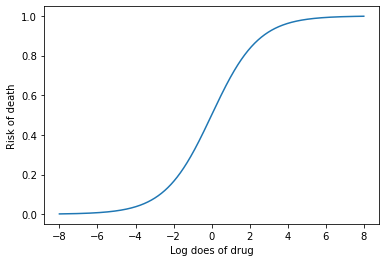

In [170]:
#to visualize the posterior with the first chain
f = lambda a, b, xp: np.exp((a*xp)+(b*xp))/(1 + np.exp((a*xp)+(b*xp)))

xp = np.linspace(-8, 8, 1000)
a = beta_list
b = theta_list
plt.plot(xp, f(a, b, xp)),
plt.xlabel('Log does of drug')
plt.ylabel('Risk of death');

                    rank         waic    p_waic      d_waic    weight  \
Dur-pout-pr            0   436.378287  4.696171    0.000000  0.578289   
Dur-pout-pr-dw(NC)     1   436.714460  6.392790    0.336173  0.421711   
Dur                    2   525.040829  2.304470   88.662543  0.000000   
Dur-ca                 3  1294.079029  2.840873  857.700743  0.000000   

                           se        dse  warning waic_scale  
Dur-pout-pr         34.784903   0.000000    False   deviance  
Dur-pout-pr-dw(NC)  35.674755   2.879423    False   deviance  
Dur                 38.438428  22.774960    False   deviance  
Dur-ca              23.131636  37.502089    False   deviance  


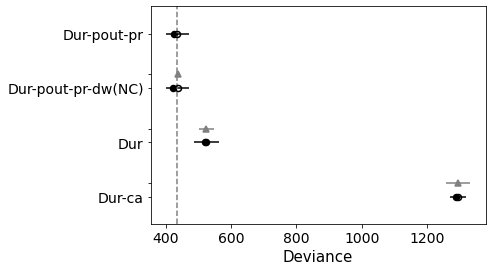

In [177]:
# Write your code here (model comparison)
compare_models = az.compare(
    {'Dur':trace_DT, 'Dur-ca':trace_CT, 'Dur-pout-pr':trace_PT,  'Dur-pout-pr-dw(NC)':trace_NMPT} 
     ,
    scale="deviance", ic = "waic"
)
compare_models

print(compare_models)
ax = az.plot_compare(compare_models)

In [178]:
compare_models

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Dur-pout-pr,0,436.378287,4.696171,0.000000,0.578289,34.784903,0.000000,False,deviance
Dur-pout-pr-dw(NC),1,436.714460,6.392790,0.336173,0.421711,35.674755,2.879423,False,deviance
Dur,2,525.040829,2.304470,88.662543,0.000000,38.438428,22.774960,False,deviance
Dur-ca,3,1294.079029,2.840873,857.700743,0.000000,23.131636,37.502089,False,deviance


According to the model comparison given above, the model included only duration(Dur), and the model included duration with the campaign(Dur-ca) have the lowest performance to explain the target. The model with the last call duration, the previous campaign outcome, and the number of contacts performed before this campaign is the highest performed model. It means that the additional attributes/features(poutcome and previous) gave more information and contribution to detecting and explaining the target. The model that takes into account the day of the week also has high performance because of the other features(poutcome, previous, and duration) contribution. Thus, the day of the week does not have any individual effect on the target.

Except for the multilevel centered model, the other models have good R hat and effective sample sizes. And also Non-centered version of the model gives proper results. And the trace plots of the Markov chain of the models were clean, healthy Markov chains, both stationary and well mixing except for the centered model.

# Additional Studies

In this academic paper about the Bank telemarketing dataset, the attribute of 'euribor3m' was considered the most relevant attribute. It seems to have a high effect on the target. According to Moro et. al [*] The Euribor affects savings rate, turning clients more likely to perform savings while Euribor decreased. It's a really strong assumption for the target. Even if the aim of the project was to analyze the effect of the marketing actions, the effect of euribor3m from the social and economic context attributes was modeled to observe this mentioned effect. 


According to the DAG, ’euribor3m’ has a direct relation to the target. There is no back door between the 'euribor3m' and the target.

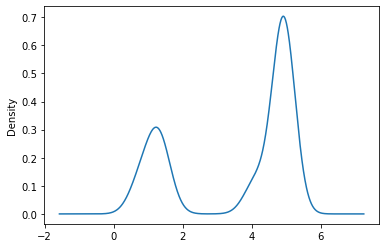

In [182]:
df['euribor3m'].plot(kind='kde')

In [183]:
#standardize the number of contacts performed during this campaign and for this client (current)
df['e3']= (df['euribor3m']-df['euribor3m'].mean())/df['euribor3m'].std()

In [190]:
#encode the features have more than one option
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()

#encode the previous outcome
df["mo"] = le.fit_transform(df['month'])
print(dict(zip(le.classes_, range(len(le.classes_)))))

{'apr': 0, 'aug': 1, 'dec': 2, 'jul': 3, 'jun': 4, 'mar': 5, 'may': 6, 'nov': 7, 'oct': 8, 'sep': 9}


In [191]:
d = df.sample(frac=0.25, replace=True, random_state=1)

In [186]:
#euribor3m -> target (total)
#logit(pi)=α+βxi
with pm.Model() as model_E3:
    alpha = pm.Normal('alpha', 0, 1.5) #intercept
    beta = pm.Normal('beta', 0, 1)  #euribor3m
    p = pm.math.invlogit(alpha + beta * d.e3)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_E3 = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, alpha]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1163 seconds.


In [188]:
df.month.value_counts()

may    1378
jul     711
aug     636
jun     530
nov     446
apr     215
oct      69
sep      64
mar      48
dec      22
Name: month, dtype: int64

In [189]:
az.summary(trace_E3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,-2.370,0.126,-2.618,-2.157,0.003,0.002,2379.0,1870.0,1.0
beta,-0.696,0.106,-0.889,-0.499,0.002,0.002,2549.0,2647.0,1.0


The model below was created by using month and the Euro Interbank Offered Rate. The month values are added as a cluster into the model. Because the Euro Interbank Offered Rate is published for 3 months and according to the month value this rate can differentiate. The non-centered multilevel model approach was used.

In [194]:
#apply multilevel model to look month affect
#add the month
#logit(pi)=βxi(euribor3m)+ gamma[i as a cluster]
#make noncentered

with pm.Model() as model_NE3:
    #to multilevel month
    gamma_bar = pm.Normal('gamma_bar', 0, 1.5) #gamma bar for each cluster
    sigma = pm.Exponential('sigma', 1) #each month the answer of customer can change
    z = pm.Normal('z', 0.0, 1.0, shape = 10)
    
    beta = pm.Normal('beta', 0, 1)  #GLM page 41

    p = pm.math.invlogit(beta * d.e3 + gamma_bar + z[d.mo]*sigma)
    A = pm.Bernoulli('A', p = p, observed = d.t)  #acceptance
    trace_NE3 = pm.sample(1000, return_inferencedata = True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: divide by zero encountered in log
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\Asus\anaconda3\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in multiply
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [beta, z, sigma, gamma_bar]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5608 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


In [195]:
az.summary(trace_NE3)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
gamma_bar,-2.001,0.354,-2.645,-1.317,0.012,0.009,919.0,755.0,1.0
z[0],-1.015,0.536,-2.064,-0.063,0.012,0.009,1890.0,2477.0,1.0
z[1],0.102,0.474,-0.754,1.015,0.012,0.009,1461.0,1838.0,1.0
z[2],-0.106,0.818,-1.618,1.407,0.015,0.013,2861.0,2504.0,1.0
z[3],-0.022,0.479,-0.929,0.878,0.012,0.008,1605.0,2463.0,1.0
z[4],0.264,0.486,-0.616,1.197,0.012,0.009,1532.0,1987.0,1.0
z[5],1.375,0.679,0.081,2.618,0.015,0.011,2194.0,2480.0,1.0
z[6],-1.833,0.591,-2.995,-0.791,0.017,0.012,1250.0,1336.0,1.0
z[7],0.036,0.476,-0.873,0.933,0.012,0.008,1619.0,2099.0,1.0
z[8],0.207,0.625,-0.986,1.366,0.013,0.010,2464.0,2005.0,1.0


     rank        waic    p_waic     d_waic   weight         se        dse  \
NE3     0  568.216213  9.520077   0.000000  0.97908  39.764894   0.000000   
E3      1  614.182775  2.139739  45.966563  0.02092  40.374900  13.148565   

     warning waic_scale  
NE3    False   deviance  
E3     False   deviance  


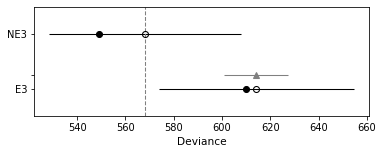

In [196]:
# Write your code here (model comparison)
compare_models_eu = az.compare(
    {'E3':trace_E3, 'NE3':trace_NE3} 
     ,
    scale="deviance", ic = "waic"
)
compare_models_eu

print(compare_models_eu)
ax = az.plot_compare(compare_models_eu)

In [197]:
compare_models_eu

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
NE3,0,568.216213,9.520077,0.000000,0.97908,39.764894,0.000000,False,deviance
E3,1,614.182775,2.139739,45.966563,0.02092,40.374900,13.148565,False,deviance


According to the model comparison, the model with month has higher performance than the other model. It shows that the Euro Interbank Offered Rate value and target are affected by the change in the month value.

Additional studies can be done by analyzing the effect of social and economic factors on the target. But there are really detailed balances between these attributes. These attributes should be searched in detailly before starting the modeling.